In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Estimates from Sample Covariance

### Monthly Returns
Since we will generate cosine similarity estimates in the next notebook using business description of companies from 2016 to 2018. We only consider monthly returns before 2019.

In [3]:
#returns_data = pd.read_csv('../data/returns_2018_top5_SIC.csv', 
#                      parse_dates = ['DATE'], 
#                      usecols = ["trt1m", "CIK", "name", "DATE"])

In [36]:
# TAKE OUT THE DATA before 2019 and reset index
#end_date = pd.to_datetime('2019-01-01')
#returns = returns_data.loc[returns_data['DATE'] < end_date]

# drop the missing value
#returns = returns.dropna()
# group the data by name and date
#group_returns = returns.groupby(['name', 'DATE'])
# calculate the percentage return
#group_returns_pct = group_returns.agg({"trt1m": (lambda x:  x/100)})
#r_selected = group_returns_pct.unstack()
# drop the first index
#r_selected.columns = r_selected.columns.droplevel(0)

In [40]:
# there are some rows containing more than one float number (array of multiple returns)
#for i in range(len(r_selected)):
#    if type(r_selected.iloc[i,1]) == np.ndarray:
#        r_selected = r_selected.drop(index = r_selected.index[i])
# convert object to float
#r_selected = r_selected.astype(float)
# drop missing values rows
#r_selected = r_selected.dropna()
#r_selected.to_csv("filtered_r.csv")
# get the mean of all 
#mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
#cov = r_selected.T.cov()

In [92]:
r_selected = pd.read_csv("filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [8]:
## Cosine Similarity

In [94]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

In [95]:
from sklearn.feature_extraction.text import CountVectorizer

Vectorizer = CountVectorizer(ngram_range = (2,4), 
                             max_features = 600)

count_data = Vectorizer.fit_transform(df['coDescription_stopwords'])
wordsCount = pd.DataFrame(count_data.toarray(),columns=Vectorizer.get_feature_names_out())
wordsCount = wordsCount.set_index(df['name'])

In [96]:
#### Cosine Similarity Computation

In [97]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = pd.DataFrame(cosine_similarity(wordsCount, wordsCount))
cosine_sim = cosine_sim.set_index(df['name'])
cosine_sim.columns = df['name']
#cosine_sim

### Perform Mean-Variance Analysis

In [98]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

In [99]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [100]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

#### Mean and Covariance for Returns in the Pharmaceutical Preparations Industry

In [101]:
mu_Pharm = mu[LIST]

In [102]:
tmp = cov[LIST].T
cov_Pharm = tmp[LIST]

In [103]:
#### Cosine Similarity Distances in the Pharmaceutical Preparations Industry

In [104]:
tmp = cosine_sim[LIST].drop_duplicates().T
Pharm_cos_sim = tmp[LIST].drop_duplicates()

In [105]:
#### Covariance for Cosine Similarity

In [106]:
cos_sim_sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_Pharm))))
cos_sim_sd = cos_sim_sd.set_index(cov_Pharm.index)
cos_sim_sd.columns = cov_Pharm.index

In [107]:
cos_sim_cov = pd.DataFrame((np.dot(np.dot(cos_sim_sd, Pharm_cos_sim),cos_sim_sd)))

### Minmum Volatility Portfolio Weights 

#### Comparing sample mean and covariance

In [108]:
mu_Pharm

name
TONIX PHARMACEUTICALS HOLDING CORP.   -0.091454
CYMABAY THERAPEUTICS, INC.             0.063536
XOMA CORP                              0.027546
CARA THERAPEUTICS, INC.                0.041563
HORIZON PHARMA PLC                     0.011321
                                         ...   
CYTOMX THERAPEUTICS, INC.              0.022405
PFIZER INC                             0.011145
CONCERT PHARMACEUTICALS, INC.          0.014813
RETROPHIN, INC.                        0.015130
CATALYST PHARMACEUTICALS, INC.         0.058129
Length: 124, dtype: float64

In [109]:
cov_Pharm

name,TONIX PHARMACEUTICALS HOLDING CORP.,"CYMABAY THERAPEUTICS, INC.",XOMA CORP,"CARA THERAPEUTICS, INC.",HORIZON PHARMA PLC,"ASSEMBLY BIOSCIENCES, INC.","CYCLACEL PHARMACEUTICALS, INC.",INTERCEPT PHARMACEUTICALS INC,MARINUS PHARMACEUTICALS INC,ACADIA PHARMACEUTICALS INC,...,"SAREPTA THERAPEUTICS, INC.",ARQULE INC,ACHAOGEN INC,BIODELIVERY SCIENCES INTERNATIONAL INC,"THERAPEUTICSMD, INC.","CYTOMX THERAPEUTICS, INC.",PFIZER INC,"CONCERT PHARMACEUTICALS, INC.","RETROPHIN, INC.","CATALYST PHARMACEUTICALS, INC."
name,,,,,,,,,,,,,,,,,,,,,
TONIX PHARMACEUTICALS HOLDING CORP.,0.065843,0.023016,0.009765,0.004046,-0.001439,-0.004349,0.010930,-0.005596,0.016549,-0.001785,...,-0.012764,0.012465,0.017652,0.009037,0.008163,-0.006814,-0.000593,0.003213,-0.004944,0.008700
"CYMABAY THERAPEUTICS, INC.",0.023016,0.060813,0.013594,0.008657,0.000766,-0.003386,-0.013297,-0.001538,0.018308,0.002903,...,-0.006259,-0.002345,0.005435,0.002469,0.006606,0.007361,0.001532,0.008448,0.002497,0.010543
XOMA CORP,0.009765,0.013594,0.068901,0.004056,0.005559,0.008817,0.006130,-0.007029,0.065473,0.009431,...,0.001142,-0.008155,-0.017001,-0.008406,0.010016,0.018039,0.005353,0.022237,0.003540,0.013079
"CARA THERAPEUTICS, INC.",0.004046,0.008657,0.004056,0.044077,0.004394,0.009793,0.003389,0.010558,0.029585,0.014410,...,0.035254,0.019356,0.011567,0.000958,0.010204,0.009315,0.000831,0.004195,0.011287,0.008936
HORIZON PHARMA PLC,-0.001439,0.000766,0.005559,0.004394,0.014189,-0.003719,0.000283,0.004942,0.009777,0.006961,...,0.007223,0.008261,-0.009825,-0.000087,0.007120,0.002175,0.001550,0.004434,0.007675,0.002063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"CYTOMX THERAPEUTICS, INC.",-0.006814,0.007361,0.018039,0.009315,0.002175,0.003610,0.007052,0.000756,0.015224,0.001914,...,0.015172,-0.000768,0.007474,-0.005921,0.003533,0.024791,0.000481,0.013797,0.008169,0.009837
PFIZER INC,-0.000593,0.001532,0.005353,0.000831,0.001550,-0.000833,0.001000,0.002369,0.005779,0.002655,...,0.000009,-0.000737,-0.000963,-0.001289,0.002476,0.000481,0.001698,0.000957,0.001162,-0.000001
"CONCERT PHARMACEUTICALS, INC.",0.003213,0.008448,0.022237,0.004195,0.004434,0.001146,0.006498,-0.002229,0.019293,0.004547,...,0.001043,0.004271,0.011584,-0.000319,0.012489,0.013797,0.000957,0.041740,-0.001181,0.025306


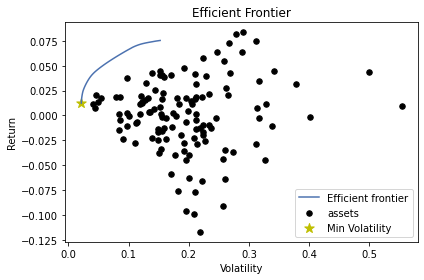

In [110]:
ef1 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="y", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns.png', dpi=200, bbox_inches='tight')
plt.show()

##### min volatility

In [111]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.2%
Annual volatility: 2.1%
Sharpe Ratio: -0.35


In [112]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        print(company, weight)

ASSEMBLY BIOSCIENCES, INC. 0.05775
JOHNSON & JOHNSON 0.17878
RECRO PHARMA, INC. 0.0201
MERCK & CO., INC. 0.2
XENON PHARMACEUTICALS INC. 0.0135
ORAMED PHARMACEUTICALS INC. 0.04982
STEMLINE THERAPEUTICS INC 0.04273
ZOETIS INC. 0.01195
IMPRIMIS PHARMACEUTICALS, INC. 0.04181
MANNKIND CORP 0.02048
VTV THERAPEUTICS INC. 0.02372
HEAT BIOLOGICS, INC. 0.00297
PFENEX INC. 0.03777
LIPOCINE INC. 0.00683
CHEMBIO DIAGNOSTICS, INC. 0.02843
PROPHASE LABS, INC. 0.0512
BRISTOL MYERS SQUIBB CO 0.12824
ARATANA THERAPEUTICS, INC. 0.03678
ACHAOGEN INC 0.00515
BIODELIVERY SCIENCES INTERNATIONAL INC 0.0368
CYTOMX THERAPEUTICS, INC. 0.0052


In [113]:
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
import dataframe_image as dfi
min_vol.dfi.export('min_vol_returns.png')

[0416/224904.862343:INFO:headless_shell.cc(659)] Written to file /var/folders/6t/0lh6qmkn1zg8fhlp984cpxrr0000gn/T/tmpkda4gscp/temp.png.


In [114]:
min_vol

,Company_Name,Weight
0,"ASSEMBLY BIOSCIENCES, INC.",0.05775
1,JOHNSON & JOHNSON,0.17878
2,"RECRO PHARMA, INC.",0.02010
3,"MERCK & CO., INC.",0.20000
4,XENON PHARMACEUTICALS INC.,0.01350
5,ORAMED PHARMACEUTICALS INC.,0.04982
6,STEMLINE THERAPEUTICS INC,0.04273
7,ZOETIS INC.,0.01195
8,"IMPRIMIS PHARMACEUTICALS, INC.",0.04181
9,MANNKIND CORP,0.02048
